### Model applied to local machine with face detection

In [1]:
import sys
import random
import os
import warnings

import numpy as np
# import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
import glob

from PIL import Image
import glob

import tensorflow as tf
import time
import cv2

In [2]:
!which python
!PATH
print(sys.path)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

/d/ANACONDA/envs/CondaTF/python
PATH=D:\ANACONDA\envs\CondaTF;D:\ANACONDA\envs\CondaTF\Library\mingw-w64\bin;D:\ANACONDA\envs\CondaTF\Library\usr\bin;D:\ANACONDA\envs\CondaTF\Library\bin;D:\ANACONDA\envs\CondaTF\Scripts;D:\ANACONDA\envs\CondaTF\bin;D;C:\Program Files\Git\ANACONDA;D;C:\Program Files\Git\ANACONDA\Library\mingw-w64\bin;D;C:\Program Files\Git\ANACONDA\Library\usr\bin;D;C:\Program Files\Git\ANACONDA\Library\bin;D;C:\Program Files\Git\ANACONDA\Scripts;D;C:\Program Files\Git\ANACONDA\bin;D;C:\Program Files\Git\ANACONDA\Scripts\condabin;C:\Users\Tom Zhou\bin;C:\Program Files\Git\mingw64\bin;C:\Program Files\Git\usr\local\bin;C:\Program Files\Git\usr\bin;C:\Program Files\Git\usr\bin;C:\Program Files\Git\mingw64\bin;C:\Program Files\Git\usr\bin;C:\Users\Tom Zhou\bin;D:\Softwares\python_27;D:\Softwares\python_27\Scripts;D:\Softwares\python_37\Scripts;D:\Softwares\python_37;C:\windows\system32;C:\windows;C:\windows\System32\Wbem;C:\windows\System32\WindowsPowerShell\v1.0;C:\window

In [3]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

sample_dir = "../NewDataset/train/img/"
mask_dir = "../NewDataset/train/mask/"
test_sample_dir = "../dataset_kaggle/testing/sample/"
test_mask_dir = "../dataset_kaggle/testing/mask/"

In [4]:
#Get the filenames of training and testing data
sample_ids = None
test_sample_ids = None
sample_ids = next(os.walk(sample_dir))[2]
test_sample_ids = next(os.walk(test_sample_dir))[2]
print(sample_ids[:10])
print(test_sample_ids[:10])

['1803151818-00000003.png', '1803151818-00000004.png', '1803151818-00000006.png', '1803151818-00000007.png', '1803151818-00000008.png', '1803151818-00000009.png', '1803151818-00000010.png', '1803151818-00000012.png', '1803151818-00000015.png', '1803151818-00000017.png']
['00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png']


In [5]:
def dilated_conv_block(input_tensor, num_filters):
    '''
    Number of filters (num_filters) : the number of input and output channels.
        the block doesn't change output shape
    
    NOTE
        set the the depth separable convolution's filter_num to different sizes
            and see how the parameters change.

    '''
    # Direct 1x1 convolution
    encoderONE = layers.Conv2D(int(num_filters/4), (1,1), padding = "same", use_bias=False)(input_tensor)
    encoderONE = layers.BatchNormalization()(encoderONE)
    encoderONE = layers.Activation('relu')(encoderONE)
    
    #1x1 convolution
    encoderTWO = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    # 5x5 depthwise separable convolution stride 1 dilation_rate = 2
    encoderTWO = layers.SeparableConv2D(int(num_filters/4), (5,5), dilation_rate = 2, padding = "same", use_bias=False, depth_multiplier=2)(encoderTWO)
    encoderTWO = layers.BatchNormalization()(encoderTWO)
    encoderTWO = layers.Activation('relu')(encoderTWO)
    
    #1x1 convolution
    encoderTHR = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    # 3x3 depthwise separable convolution stride 1 dilation_rate = 2
    encoderTHR = layers.SeparableConv2D(int(num_filters/4), (3,3), dilation_rate = 2, padding = "same", use_bias=False, depth_multiplier=2)(encoderTHR)
    encoderTHR = layers.BatchNormalization()(encoderTHR)
    encoderTHR = layers.Activation('relu')(encoderTHR)
    
    #1x1 convolution
    encoderFOUR = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    # 5x5 depthwise separable convolution stride 1 dilation_rate = 2
    encoderFOUR = layers.SeparableConv2D(int(num_filters/4), (5,5), dilation_rate = 3, padding = "same", use_bias=False, depth_multiplier=2)(encoderFOUR)
    encoderFOUR = layers.BatchNormalization()(encoderFOUR)
    encoderFOUR = layers.Activation('relu')(encoderFOUR)
    
    encoderOUT = layers.concatenate([encoderFOUR,encoderTHR, encoderTWO, encoderONE], axis=-1)
    #Final 1x1 convolution with relu to make sure the output have the same channels as input
#     encoderOUT = layers.Conv2D(num_filters, (1,1), padding = "same", use_bias=False)(encoderOUT)
#     encoderOUT = layers.Activation("relu")(encoderOUT)

    return encoderOUT

def downsample_block(input_tensor, num_filters):
    
    #Store the input to this "max_pooling layer" for skip connections
    store_feature =  layers.Conv2D(int(num_filters/4), (1,1), padding = "same", use_bias=False)(input_tensor)
    
    encoder = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    
    # 2x2 max_pooling with stride 2
    encoderONE = layers.MaxPooling2D((2, 2), strides=(2, 2))(input_tensor) #already have output dimension desired

    # 5x5 depthwise separable convolution stride = 2
    encoderTWO = layers.ZeroPadding2D(padding=(2, 2))(encoder) # zero-padding (2,2) to keep output dimension consistent
    encoderTWO = layers.SeparableConv2D(num_filters, (5,5), strides = 2, use_bias=False)(encoderTWO)
    encoderTWO = layers.BatchNormalization()(encoderTWO)
    encoderTWO = layers.Activation('relu')(encoderTWO)
    
    # 3x3 depthwise separable convolution stride = 2
    encoderTHR = layers.ZeroPadding2D(padding = (1,1))(encoder) # zero-padding (1,1) to keep output dimension consistent
    encoderTHR = layers.SeparableConv2D(num_filters, (3,3), strides = 2, use_bias=False)(encoderTHR)
    encoderTHR = layers.BatchNormalization()(encoderTHR)
    encoderTHR = layers.Activation('relu')(encoderTHR) 

    
    # 7x7 depthwise separable convolution stride = 2
    encoderFOUR = layers.ZeroPadding2D(padding=(3, 3))(encoder) # zero-padding (3,3)to keep output dimension consistent
    encoderFOUR = layers.SeparableConv2D(num_filters, (7,7), strides = 2, use_bias=False)(encoderFOUR)
    encoderFOUR = layers.BatchNormalization()(encoderFOUR)
    encoderFOUR = layers.Activation('relu')(encoderFOUR)
 
    #By now the encoderOUT has shape reduced to 1/2 of input shape
    encoderOUT = layers.concatenate([encoderFOUR, encoderTHR, encoderTWO, encoderONE], axis=-1)
    #Final 1x1 convolution with relu to make sure the output have 2 times channels as input
    encoderOUT = layers.Conv2D(num_filters*2, (1,1), padding = "same", use_bias=False)(encoderOUT)
    encoderOUT = layers.Activation("relu")(encoderOUT)
    
    return store_feature, encoderOUT

def decoder_block(input_tensor, concat_tensor, num_filters):
    
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
#     decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder)
#     decoder = layers.BatchNormalization()(decoder)
#     decoder = layers.Activation('relu')(decoder)
    return decoder

In [6]:
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(img_shape)

inputs = layers.Input(shape=img_shape)
initial_block_2 = layers.MaxPool2D((2,2), strides = 2)(inputs)

#Now modify the inputs
initial_block_1 = layers.ZeroPadding2D(padding = (1,1))(inputs)
initial_block_1 = layers.Conv2D(29, (3,3), strides = 2, use_bias = False)(initial_block_1)

initial_block = layers.concatenate([initial_block_1, initial_block_2], axis = -1)

# 256
encoder0 = dilated_conv_block(initial_block, 32)
encoder0, encoder0_pool = downsample_block(encoder0, 32)

# 128
encoder1 = dilated_conv_block(encoder0_pool, 64)
encoder1, encoder1_pool = downsample_block(encoder1, 64)

# 64
encoder2 = dilated_conv_block(encoder1_pool, 128)
encoder2, encoder2_pool = downsample_block(encoder2, 128)

# 32
encoder3 = dilated_conv_block(encoder2_pool, 256)
encoder3, encoder3_pool = downsample_block(encoder3, 256)

# 16
# encoder4 = dilated_conv_block(encoder3_pool, 512)
# encoder4, encoder4_pool = downsample_block(encoder4, 512)

# 32
center = dilated_conv_block(encoder3_pool, 512)
center = dilated_conv_block(center, 512)

# 64
decoder3 = decoder_block(center, encoder3, 256)
# 128
decoder2 = decoder_block(decoder3, encoder2, 128)
# 256
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
final = layers.UpSampling2D((2,2), interpolation= "bilinear")(decoder0)
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(final)

model = None
model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

(512, 512, 3)


W0805 17:09:02.085910  2328 deprecation.py:506] From D:\ANACONDA\envs\CondaTF\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 29) 783         zero_padding2d[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

conv2d_7 (Conv2D)               (None, 128, 128, 64) 8192        concatenate_2[0][0]              
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 128, 128, 64) 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 32) 2048        activation_7[0][0]               
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 32) 2048        activation_7[0][0]               
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 32) 2048        activation_7[0][0]               
__________________________________________________________________________________________________
separable_

separable_conv2d_14 (SeparableC (None, 64, 64, 32)   7296        conv2d_18[0][0]                  
__________________________________________________________________________________________________
separable_conv2d_13 (SeparableC (None, 64, 64, 32)   5248        conv2d_17[0][0]                  
__________________________________________________________________________________________________
separable_conv2d_12 (SeparableC (None, 64, 64, 32)   7296        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 32)   4096        activation_15[0][0]              
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 64, 64, 32)   128         separable_conv2d_14[0][0]        
__________________________________________________________________________________________________
batch_norm

batch_normalization_23 (BatchNo (None, 32, 32, 64)   256         separable_conv2d_19[0][0]        
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 32, 32, 64)   256         separable_conv2d_18[0][0]        
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 32, 64)   256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 32, 32, 64)   0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 32, 32, 64)   0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
activation

activation_33 (Activation)      (None, 16, 16, 128)  0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 16, 16, 128)  0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 16, 16, 512)  0           activation_35[0][0]              
                                                                 activation_34[0][0]              
                                                                 activation_33[0][0]              
                                                                 activation_32[0][0]              
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 256)  131072      concatenate_9[0][0]              
__________

concatenate_13 (Concatenate)    (None, 128, 128, 80) 0           conv2d_12[0][0]                  
                                                                 conv2d_transpose_2[0][0]         
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 128, 128, 80) 320         concatenate_13[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 128, 128, 80) 0           batch_normalization_40[0][0]     
__________________________________________________________________________________________________
separable_conv2d_32 (SeparableC (None, 128, 128, 64) 5904        activation_44[0][0]              
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 128, 128, 64) 256         separable_conv2d_32[0][0]        
__________

In [7]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [8]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

def myIOU(y_true, y_pred):
    smooth = 0.001
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

In [9]:
opt = tf.keras.optimizers.Adam(lr =0.002)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[dice_loss, myIOU])

W0805 17:09:07.064249  2328 deprecation.py:323] From D:\ANACONDA\envs\CondaTF\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model = models.load_model("./myIOU_weights.hdf5", custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss, 'myIOU':myIOU})

W0805 17:09:07.277031  2328 deprecation.py:506] From D:\ANACONDA\envs\CondaTF\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 17:09:07.278521  2328 deprecation.py:506] From D:\ANACONDA\envs\CondaTF\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 17:09:07.285961  2328 deprecation.py:506] From D:\ANACONDA\envs\CondaTF\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be rem

In [11]:
X_test = []
Y_test = []
THRES = 70
TEST_NUM =20
for n, id_ in tqdm(enumerate(test_sample_ids[:TEST_NUM]), total=TEST_NUM):
    test_sample_path = test_sample_dir + id_
    # also read in the corresponding mask
    test_mask_path = test_mask_dir + id_[:-4] + "_matte.png"
    
    img = cv2.imread(test_sample_path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    
    # Convert opencv's default BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    X_test.append(img)
    
#     print(test_mask_path)
    mask_ = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
#     print(mask_.shape)
    mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)), axis=-1)
#     print(mask_.shape)
    mask_ = (mask_ > THRES) * 255
#     print(mask_.dtype)
    mask_ = mask_.astype(np.float32)
#     print(mask_.dtype)
    Y_test.append(mask_)

100%|██████████| 20/20 [00:01<00:00, 15.66it/s]


In [12]:
print(np.array(X_test).shape)
print(np.array(Y_test).shape)

(20, 512, 512, 3)
(20, 512, 512, 1)


(20, 512, 512, 3)
(20, 512, 512, 1)


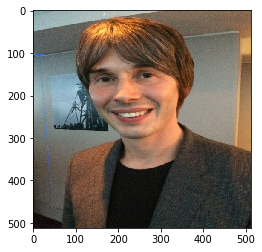

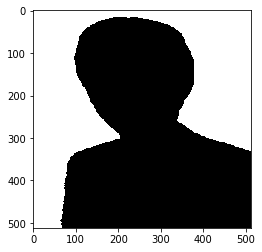

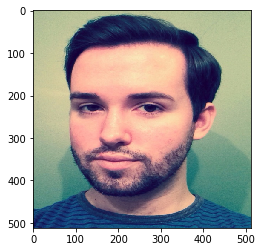

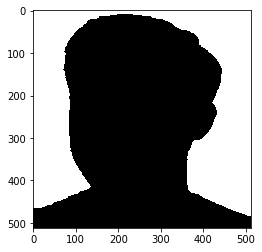

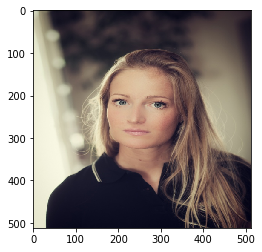

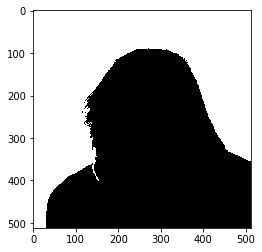

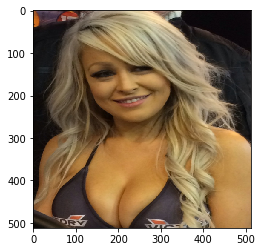

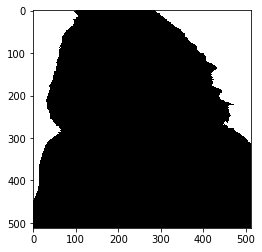

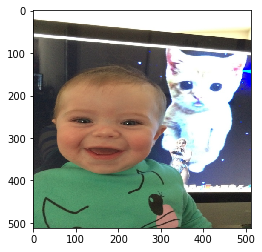

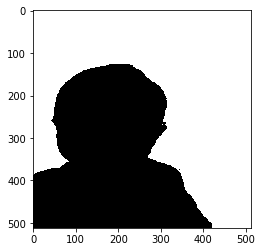

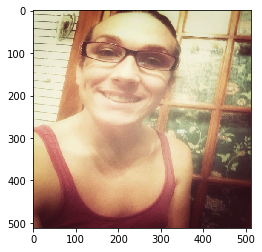

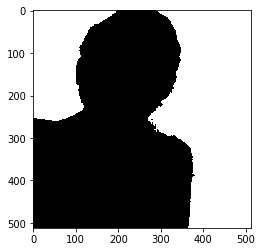

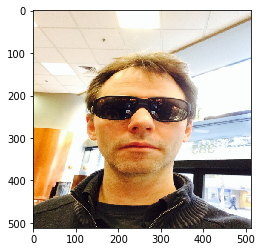

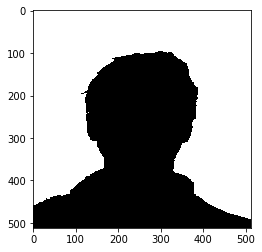

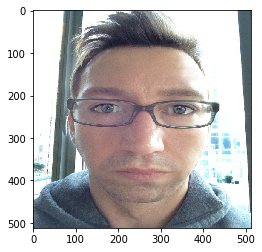

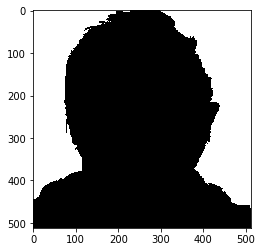

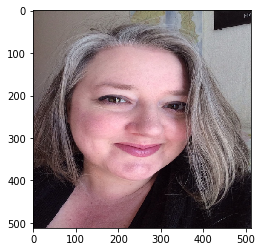

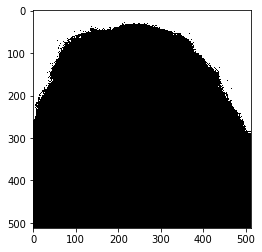

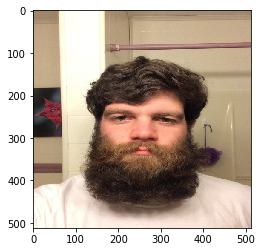

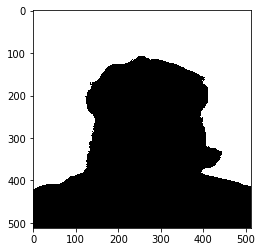

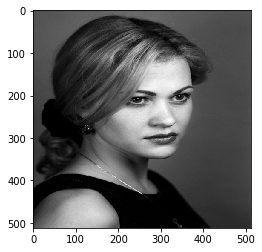

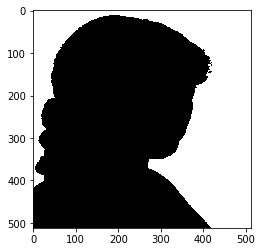

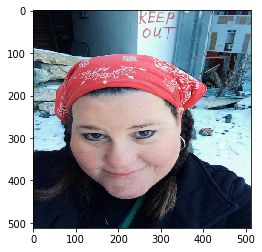

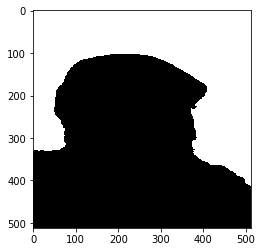

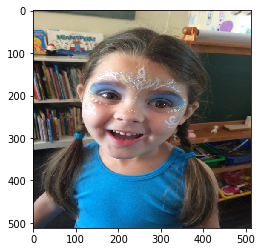

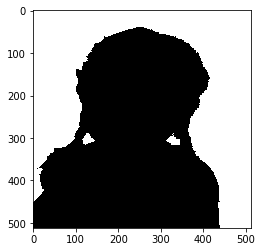

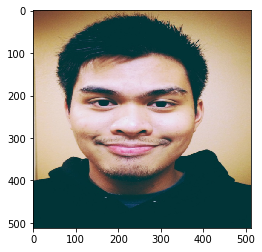

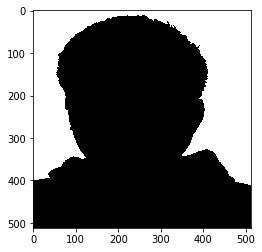

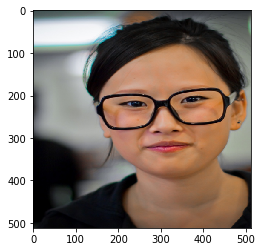

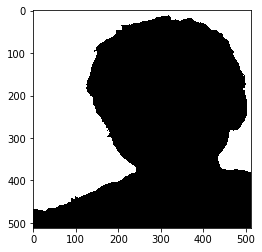

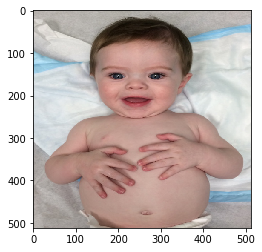

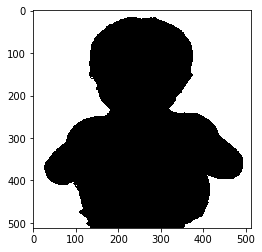

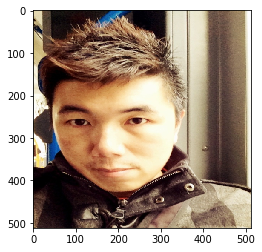

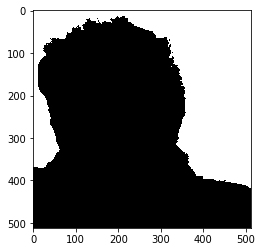

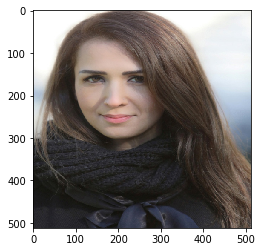

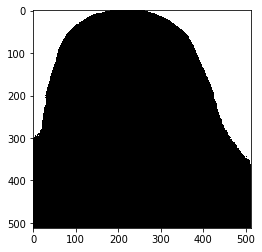

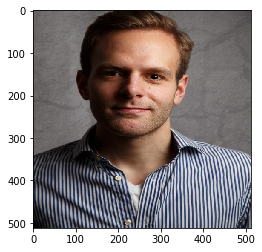

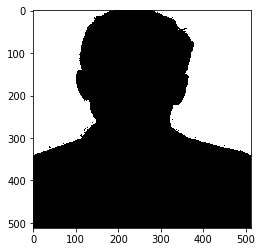

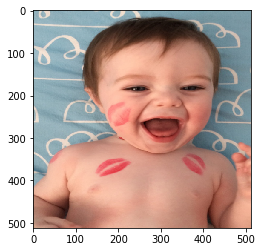

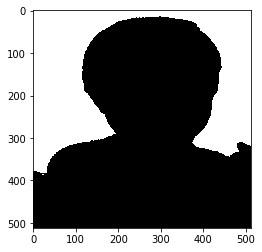

(20, 512, 512, 3)


In [13]:
test_img = np.zeros([20, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
test_mask = np.zeros([20, IMG_HEIGHT, IMG_WIDTH, 1])

imgs = None
masks = None
imgs, masks = np.array(X_test[:20])/255.0 , np.array(Y_test[:20])/255.0 
print(imgs.shape)
print(masks.shape)

for i in range(20):

    img = imgs[i]
    mask = masks[i]
    plt.imshow(img)
    plt.show()
    plt.imshow(mask[:,:,0], cmap = "Greys")
    plt.show()
    test_img[i] = img
    test_mask[i] = mask
    
    
print(test_img.shape)

In [21]:
model.evaluate_generator(np.array(X_test), np.array(Y_test), verbose = 0, steps = 1, batch_size = 1)

[1751.6923828125, 0.056676567, 46.196342]

In [19]:
predictions = model.predict(test_img, steps = 1, verbose = 1) # NOTE THAT the input values should be normalized to be between 0 and 1

1/1 [==============================] - 6s 6s/step


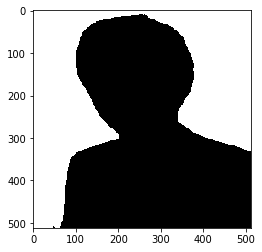

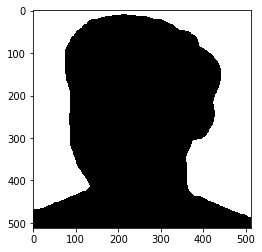

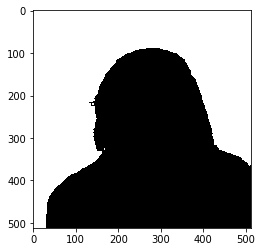

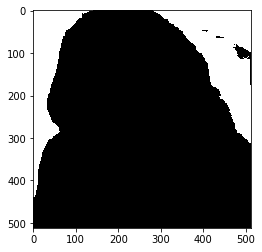

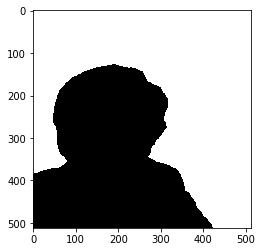

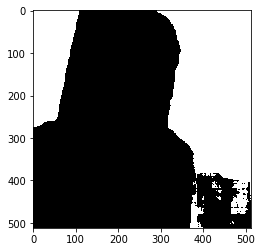

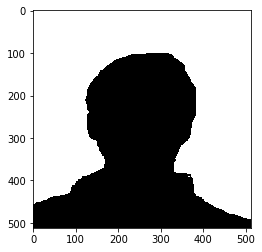

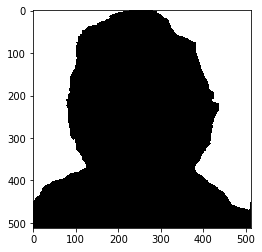

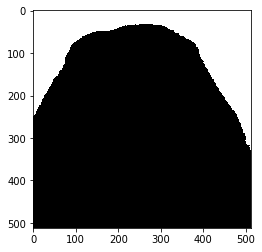

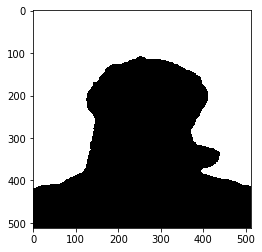

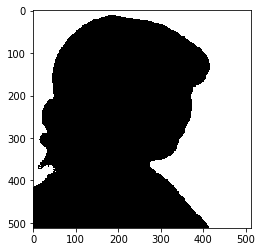

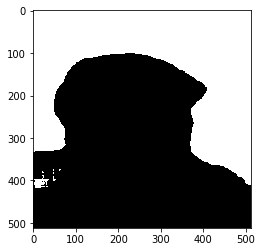

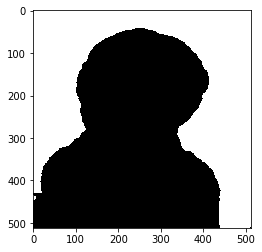

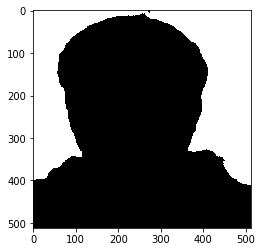

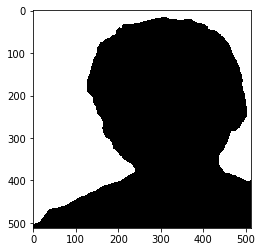

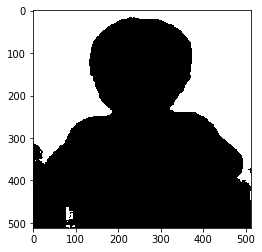

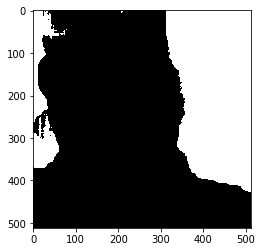

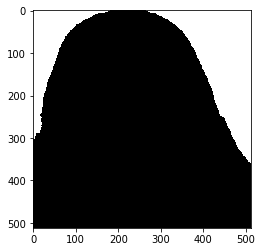

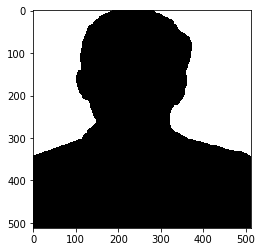

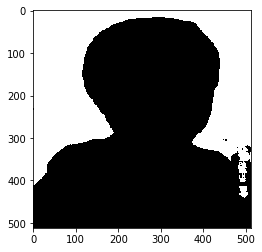

In [18]:
for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = (img>0.4) * 1
    img = np.trunc(img*255)
    img = img.astype(np.uint8)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
#     plt.imshow(Y_train[i][:,:,0], cmap = 'Greys')
    plt.show()
    